In [1]:
# Instalimi i spark. Behet vetem nje here.

# Step 1: Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Step 2: Download Spark 3.4.1 (latest confirmed working version)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Step 3: Extract Spark
!tar -xzf spark-3.4.1-bin-hadoop3.tgz

# Step 4: Install findspark
!pip install -q findspark

# Step 5: Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

In [2]:
#Na lejon me marre dataset qe eshte i ngarkuar ne google drive

!pip install -q gdown

# Download using the file ID
!gdown --id 1DB44cymNuJxmQTZlSikWCpGJZnRKn_Ka --output flight_dataset.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DB44cymNuJxmQTZlSikWCpGJZnRKn_Ka
From (redirected): https://drive.google.com/uc?id=1DB44cymNuJxmQTZlSikWCpGJZnRKn_Ka&confirm=t&uuid=b953e1ac-e017-48e0-8a52-3cca778fb804
To: /content/flight_dataset.csv
100% 227M/227M [00:02<00:00, 77.0MB/s]


In [4]:
# Krijon nje spark Session.
  # Gjendja pass mbylljes se session nuk ruhet

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigDataProject") \
    .getOrCreate()

spark

In [5]:
# E vendos datasetin si tabele temprale ne memorie. Zgjat sa sessioni i spark

flight_dataset = spark.read.csv("flight_dataset.csv", header=True, inferSchema=True)
flight_dataset.createOrReplaceTempView("flight_dataset")
flight_dataset.show(100, truncate=False)

+-----------------+------------+-----------------+------------+------------------------------------------------------------+--------------+-----------------------------------------+---------------------------+-------------------+-------------------+--------+-----+------+--------+-------------+-------------------------------+--------------+-------------------+
|from_airport_code|from_country|dest_airport_code|dest_country|aircraft_type                                               |airline_number|airline_name                             |flight_number              |departure_time     |arrival_time       |duration|stops|price |currency|co2_emissions|avg_co2_emission_for_this_route|co2_percentage|scan_date          |
+-----------------+------------+-----------------+------------+------------------------------------------------------------+--------------+-----------------------------------------+---------------------------+-------------------+-------------------+--------+-----+------+-----

+------------+------------+-----+------------+---------+-------+------------------+------------------+-------------+
|from_country|dest_country|stops|flight_count|min_price|min_co2|avg_price         |avg_co2           |price_per_co2|
+------------+------------+-----+------------+---------+-------+------------------+------------------+-------------+
|Denmark     |Thailand    |0    |6           |237.0    |1022000|316.3333333333333 |1022000.0         |3.1E-4       |
|Australia   |Vietnam     |0    |9           |180.0    |606000 |228.11111111111111|659777.7777777778 |3.46E-4      |
|Austria     |Dublin      |0    |11          |25.0     |186000 |73.81818181818181 |194909.0909090909 |3.79E-4      |
|Dublin      |Thailand    |3    |10          |367.0    |1237000|548.9             |1380100.0         |3.98E-4      |
|Dublin      |Austria     |0    |12          |28.0     |185000 |78.91666666666667 |192916.66666666666|4.09E-4      |
|Denmark     |Thailand    |3    |9           |451.0    |1161000|

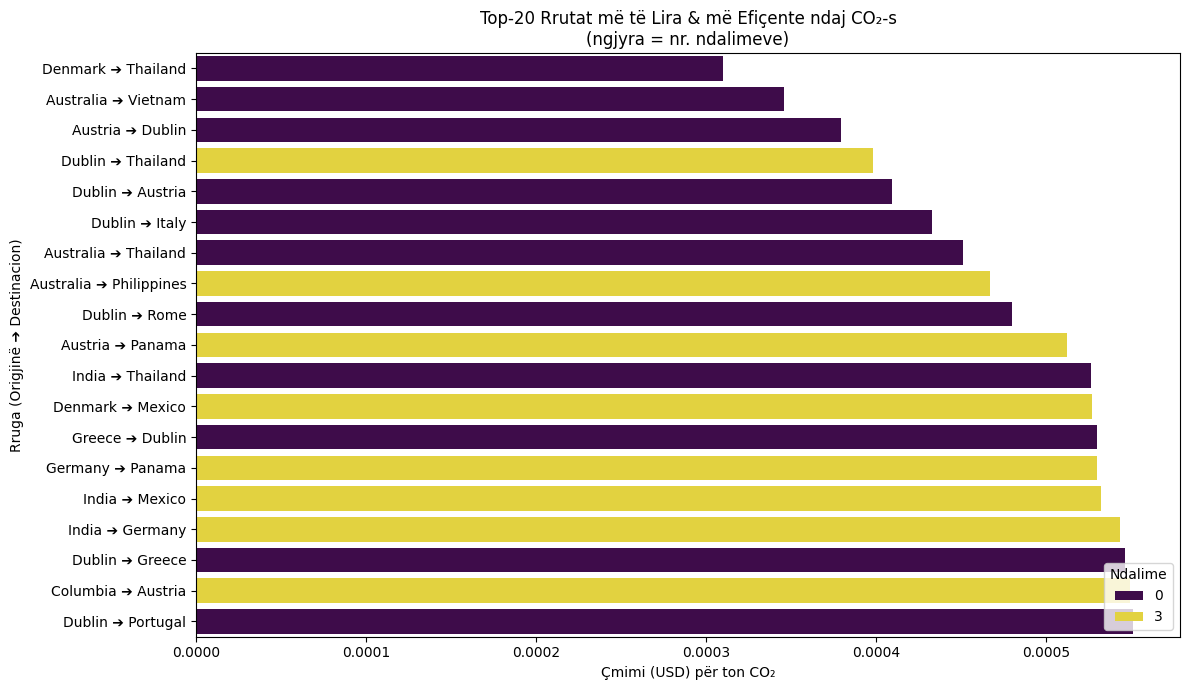

In [14]:
# Query 1: Fluturimet më të Lira kundrejt më Eco-Friendly sipas Rrugës dhe Numrit të Ndalimeve

# -----------------------------------------------------------------------------
#  1) Krijo view me statistikat çmim/CO₂ për çdo rrugë + numrin e ndalimeve
spark.sql("""
    SELECT
        from_country,
        dest_country,
        stops,
        COUNT(*)                                       AS flight_count,
        MIN(price)                                     AS min_price,
        MIN(co2_emissions)                             AS min_co2,
        AVG(price)                                     AS avg_price,
        AVG(co2_emissions)                             AS avg_co2,
        ROUND(AVG(price) / NULLIF(AVG(co2_emissions), 0), 6) AS price_per_co2
    FROM flight_dataset
    WHERE price IS NOT NULL
      AND co2_emissions IS NOT NULL
    GROUP BY from_country, dest_country, stops
    HAVING flight_count > 5           -- vetëm rute me ≥5 fluturime
    ORDER BY price_per_co2 ASC
""").createOrReplaceTempView("eco_price_stats")

# -----------------------------------------------------------------------------
#  2) Shfaq 50 rreshtat e parë (instruktori sheh rezultatet e plota)
spark.sql("""
    SELECT *
    FROM   eco_price_stats
    ORDER  BY price_per_co2 ASC
    LIMIT  50
""").show(truncate=False)

# -----------------------------------------------------------------------------
#  3) Grafiku: Bar-chart me 20 rruget më efikase (çmim/CO₂), ngjyra = nr.ndalimesh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eco_df = spark.sql("SELECT * FROM eco_price_stats").toPandas()

top20 = (
    eco_df.sort_values("price_per_co2")
          .head(20)
          .drop_duplicates(subset=["from_country", "dest_country"])  # një rresht për rruge
)

# Etiketa më e shkurtër për boshtin Y
top20["route"] = (
    top20["from_country"].str[:15] +
    " ➔ " +
    top20["dest_country"].str[:15]
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top20,
    y="route",
    x="price_per_co2",
    hue="stops",
    palette="viridis",
    dodge=False
)

plt.xlabel("Çmimi (USD) për ton CO₂")
plt.ylabel("Rruga (Origjinë ➔ Destinacion)")
plt.title("Top-20 Rrutat më të Lira & më Efiçente ndaj CO₂-s\n(ngjyra = nr. ndalimeve)")
plt.legend(title="Ndalime", loc="lower right")
plt.tight_layout()
plt.show()


+------------+--------------------+-------------+--------------+-------------+----------------+---------------+---------------------+
|from_country|dest_country        |total_flights|direct_flights|multi_flights|avg_price_direct|avg_price_multi|pct_savings_vs_direct|
+------------+--------------------+-------------+--------------+-------------+----------------+---------------+---------------------+
|Chile       |Mexico              |921          |13            |908          |2370.69         |845.13         |64.35                |
|Brazil      |Mexico              |1924         |10            |1914         |3233.5          |2257.0         |30.2                 |
|Chile       |Spain               |696          |13            |683          |2422.54         |1807.86        |25.37                |
|Germany     |Singapore           |1478         |30            |1448         |2811.1          |2143.93        |23.73                |
|France      |Netherlands         |1157         |67           

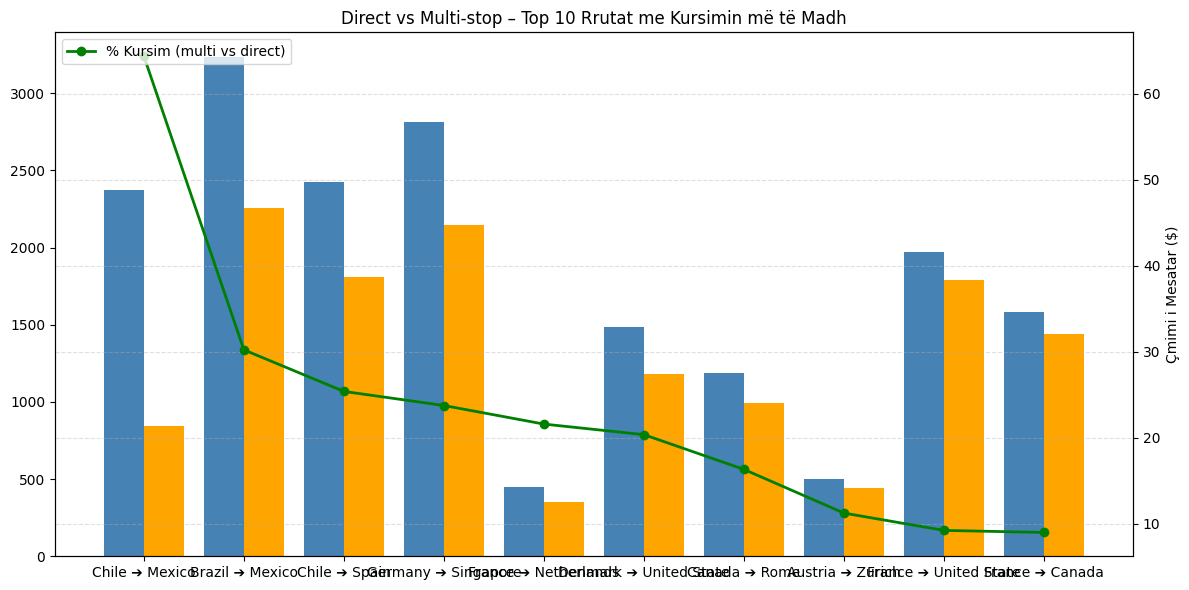

In [13]:
# QUERY 2: Sa % MË LIRË apo MË SHUMË kushton të shtosh ndalesa?

spark.sql("""
    SELECT
        from_country,
        dest_country,
        COUNT(*)                                       AS total_flights,
        SUM(CASE WHEN stops = 0 THEN 1 ELSE 0 END)    AS direct_flights,
        SUM(CASE WHEN stops > 0 THEN 1 ELSE 0 END)    AS multi_flights,
        ROUND(AVG(CASE WHEN stops = 0 THEN price END), 2) AS avg_price_direct,
        ROUND(AVG(CASE WHEN stops > 0 THEN price END), 2) AS avg_price_multi,
        ROUND(
            (AVG(CASE WHEN stops = 0 THEN price END) -
             AVG(CASE WHEN stops > 0 THEN price END)
            ) / AVG(CASE WHEN stops = 0 THEN price END) * 100
        , 2) AS pct_savings_vs_direct          -- pozitive = më lirë me ndalesa
    FROM flight_dataset
    WHERE price IS NOT NULL AND stops IS NOT NULL
    GROUP BY from_country, dest_country
    HAVING direct_flights >= 5 AND multi_flights >= 5
    ORDER BY pct_savings_vs_direct DESC
""").createOrReplaceTempView("stop_price_compare_fixed")

# ---------------------------------------------------------------
# 1) PRINT top 20 rreshtat
spark.sql("""
    SELECT *
    FROM   stop_price_compare_fixed
    ORDER  BY pct_savings_vs_direct DESC
    LIMIT  20
""").show(truncate=False)

# ---------------------------------------------------------------
# 2) Grafik kolonash: Çmimi mesatar direct vs multi (Top 10 kursimet më të mëdha)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = spark.sql("""
    SELECT from_country,
           dest_country,
           avg_price_direct,
           avg_price_multi,
           pct_savings_vs_direct
    FROM   stop_price_compare_fixed
    ORDER  BY pct_savings_vs_direct DESC
    LIMIT  10
""").toPandas()

# Label rruge
plot_df["route"] = plot_df["from_country"].str[:12] + " ➔ " + plot_df["dest_country"].str[:12]

plt.figure(figsize=(12,6))
bar_width = 0.4
positions = range(len(plot_df))

# Kolona: Çmimi direct
plt.bar(
    [p - bar_width/2 for p in positions],
    plot_df["avg_price_direct"],
    width=bar_width,
    label="Direct ($)",
    color="steelblue"
)

# Kolona: Çmimi multi-stop
plt.bar(
    [p + bar_width/2 for p in positions],
    plot_df["avg_price_multi"],
    width=bar_width,
    label="Multi-stop ($)",
    color="orange"
)

# Linjë: % kursimi mbi boshtin dytësor
plt.twinx()
plt.plot(
    positions,
    plot_df["pct_savings_vs_direct"],
    color="green",
    marker="o",
    linewidth=2,
    label="% Kursim (multi vs direct)"
)

plt.xticks(positions, plot_df["route"], rotation=45, ha="right")
plt.ylabel("Çmimi i Mesatar ($)")
plt.title("Direct vs Multi-stop – Top 10 Rrutat me Kursimin më të Madh")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
